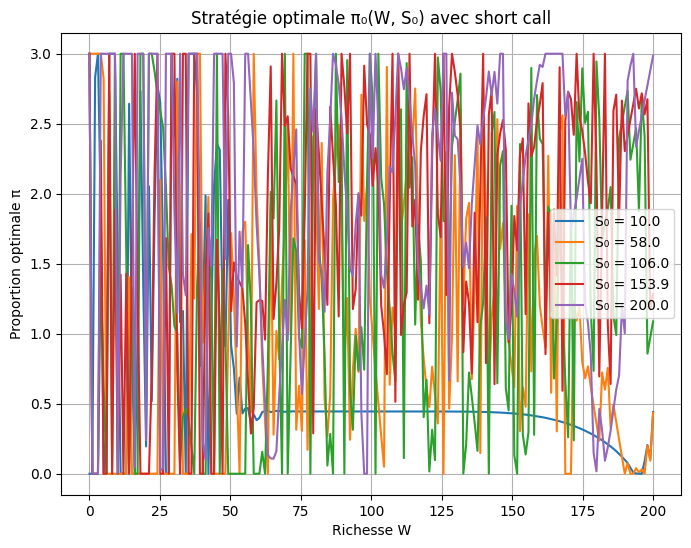

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.interpolate import RectBivariateSpline

# === Paramètres ===
r = 0.03
mu = 0.05
sigma = 0.30
gamma = 0.5
K = 100  # strike du call
T = 1.0
n = 50
p = 0.5

delta_t = T / n

# === Grilles ===
W_min, W_max = 1e-3, 200
S_min, S_max = 10, 200
N_W, N_S = 200, 100
W_grid = np.linspace(W_min, W_max, N_W)
S_grid = np.linspace(S_min, S_max, N_S)

# === Fonction utilité CRRA ===
def u(w, gamma):
    if w <= 0:
        return -1e12
    return w**(1 - gamma) / (1 - gamma) if gamma != 1 else np.log(w)

# === Initialisation terminale V_T(W, S) ===
V = {}
pi_store = {}

V[n] = np.zeros((N_W, N_S))
pi_store[n] = np.zeros((N_W, N_S))

for i, w in enumerate(W_grid):
    for j, s in enumerate(S_grid):
        payoff = max(s - K, 0.0)  # short call payoff
        V[n][i, j] = u(w - payoff, gamma)

# === Backward induction ===
for t in reversed(range(n)):
    V[t] = np.zeros((N_W, N_S))
    pi_store[t] = np.zeros((N_W, N_S))

    # Interpolateur pour V_{t+1}
    interp = RectBivariateSpline(W_grid, S_grid, V[t+1])

    for i, w in enumerate(W_grid):
        for j, s in enumerate(S_grid):

            def objective(pi):
                A = 1 + r * delta_t
                B = (mu - r) * delta_t
                C = sigma * np.sqrt(delta_t)

                s_up = s * np.exp(sigma * np.sqrt(delta_t))
                s_down = s * np.exp(-sigma * np.sqrt(delta_t))

                w_up = w * (A + pi * (B + C))
                w_down = w * (A + pi * (B - C))

                if w_up <= 0 or w_down <= 0:
                    return np.inf

                V_up = interp(w_up, s_up)[0][0]
                V_down = interp(w_down, s_down)[0][0]
                return -(p * V_up + (1 - p) * V_down)

            res = minimize_scalar(objective, bounds=(0, 3), method='bounded')
            pi_opt = res.x
            V_opt = -res.fun

            V[t][i, j] = V_opt
            pi_store[t][i, j] = pi_opt

# === Exemple : stratégie à t = 0 ===
plt.figure(figsize=(8, 6))
S_idx_plot = [0, N_S//4, N_S//2, 3*N_S//4, N_S-1]
for j in S_idx_plot:
    plt.plot(W_grid, pi_store[0][:, j], label=f"S₀ = {round(S_grid[j],1)}")

plt.title("Stratégie optimale π₀(W, S₀) avec short call")
plt.xlabel("Richesse W")
plt.ylabel("Proportion optimale π")
plt.legend()
plt.grid(True)
plt.show()
